# Introduction #

In this notebook I try to use the SNP 500's float-adjusted market cap (FMC) weighting methodology to approximate the weights used currently by the index. I use yfinance to retrieve float shares and price data and estimate weights accordingly. After the initial estimates I go back and address discrepancies (using public ETF weightings).

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib as mpl
import requests
import numpy as np
from io import StringIO
import time
import math

In [2]:
def CleanTickers(Tickers: list): # Cleans Tickers to ensure formatting of Class B stocks align with yfinance tickers. 
    for i, Ticker in enumerate(Tickers):
        Tickers[i] = Ticker.replace(".", "-")
    return Tickers

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
html = requests.get(url, headers=headers).text
df_list = pd.read_html(StringIO(html))
try:
    df = df_list[1]
    tickerslist = CleanTickers(df['Symbol'].tolist())
except:
    df = df_list[0]
    tickerslist = CleanTickers(df['Symbol'].tolist())

Note: This next cell takes a while to run

In [4]:
newtickers = tickerslist[0]
for i in tickerslist:
    newtickers += " " + i
tickers = yf.Tickers(newtickers)
CurrentFAMC = {}
for symbol, ticker in tickers.tickers.items():
    info = ticker.info
    if 'floatShares' in info and 'currentPrice' in info:
        fmc = info['floatShares'] * info['currentPrice']
        CurrentFAMC[symbol] = fmc
        print(symbol, "done. Assigned: ", fmc)
    else:
        print(1)


MMM done. Assigned:  85627883617.89
AOS done. Assigned:  7643580349.6
ABT done. Assigned:  214518666057.4
ABBV done. Assigned:  406340811123.52
ACN done. Assigned:  161215483235.8
ADBE done. Assigned:  139434903245.592
AMD done. Assigned:  358094434552.42505
AES done. Assigned:  10369565866.475
AFL done. Assigned:  57260631964.77
A done. Assigned:  38667985316.55
APD done. Assigned:  55390162768.79
ABNB done. Assigned:  54516764287.965
AKAM done. Assigned:  12049755233.070002
ALB done. Assigned:  16756769691.05
ARE done. Assigned:  7547000377.88
ALGN done. Assigned:  10485601620.0
ALLE done. Assigned:  13665849762.6
LNT done. Assigned:  16790546475.5
ALL done. Assigned:  52989533925.299995
GOOGL done. Assigned:  3367193558467.1997
GOOG done. Assigned:  3370541098724.8
MO done. Assigned:  96784090151.7295
AMZN done. Assigned:  2188968047389.6602
AMCR done. Assigned:  19234969172.64
AEE done. Assigned:  27115110194.4
AEP done. Assigned:  61897365496.29
AXP done. Assigned:  198917436880.5

# Estimates for current weights

In [5]:
TotalFMC = 0
for Symbol in CurrentFAMC:
    TotalFMC += CurrentFAMC[Symbol]

Weights = {}
WeightInvDict = {} #inverse dictionary and list used for the sake of sorting the dictionary for printing.
WeightList = []

for Symbol in CurrentFAMC:
    Weights[Symbol] = 100*CurrentFAMC[Symbol]/TotalFMC
    WeightInvDict[100*CurrentFAMC[Symbol]/TotalFMC] = Symbol
    WeightList.append(100*CurrentFAMC[Symbol]/TotalFMC)

WeightList.sort(reverse=True)
for i in WeightList:
    print(WeightInvDict[i], i)

NVDA 7.454464717675347
AAPL 6.740246681551161
MSFT 5.929858983170626
GOOG 5.697947528784625
GOOGL 5.692288464503963
AMZN 3.7004815283015757
META 2.367604100877086
TSLA 1.7834962550934257
LLY 1.6172226986369853
JPM 1.4833652100813457
V 1.0271253263645863
XOM 0.8644147975071305
MA 0.8479780793511708
JNJ 0.842040799370062
WMT 0.8259622857762386
ABBV 0.6869249039750821
BAC 0.6835064091723518
NFLX 0.6487228968875414
COST 0.642528965863733
PLTR 0.6364592306643273
AMD 0.6053637201461445
HD 0.5830242577068581
MU 0.5817279898019365
ORCL 0.5644622047589547
PG 0.560020322873861
GE 0.5600119460179702
UNH 0.5141327728822032
CSCO 0.5081730914368243
WFC 0.4969363155959956
CVX 0.4906619190561439
GS 0.4728762319980726
CAT 0.46836918355608714
IBM 0.4607286801835882
KO 0.4537007361846384
MRK 0.44484466064990025
PM 0.42534152074747034
CRM 0.3937828825653522
RTX 0.3900810593771379
LRCX 0.3814405994067384
TMO 0.375405873902508
MS 0.36645432970623093
MCD 0.363853070298319
ABT 0.3626468472977184
AMAT 0.356428

In [6]:
print(sum(WeightList))
# should add to 100%

100.00000000000001


# Fixed-weight series comparison #

Below we construct an SNP reconstruction using the fixed (current) weight estimates calculated previously. We see a that our series constructs an overestimate.

In [7]:
# PARAMETERS OF COMPARISON
Period = "1y"
Interval = "1d"

In [8]:
def NormaliseData(Data: pd.DataFrame, DataType: str, NormaliseMagnitude: bool):
    NewDataList = {}

    if DataType != "Open" and DataType != "Close":
        print("Invalid DataType")
        return

    for i in Data[DataType]:
        NewDataList[i] = Data[DataType][i].reset_index(drop = True) #Indexes with numbers for convenience, dates are irrelevant as long as periods are consistent. 
        if NormaliseMagnitude == True:
            NewDataList[i] /= NewDataList[i].iloc[-1] # normalising magnitudes

    
    return pd.DataFrame(NewDataList)

CompanyData = NormaliseData(yf.download(list(tickers.tickers.keys()), period = Period, interval = Interval), "Open", True)
SNPData = NormaliseData(yf.download("^GSPC", period = Period, interval = Interval), "Open", True)

/var/folders/71/s15_81qd3v12z0ff4q43_lg80000gn/T/ipykernel_50029/830605144.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  CompanyData = NormaliseData(yf.download(list(tickers.tickers.keys()), period = Period, interval = Interval), "Open", True)
[*********************100%***********************]  503 of 503 completed
/var/folders/71/s15_81qd3v12z0ff4q43_lg80000gn/T/ipykernel_50029/830605144.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  SNPData = NormaliseData(yf.download("^GSPC", period = Period, interval = Interval), "Open", True)
[*********************100%***********************]  1 of 1 completed


We normalise data magnitude when downloading data so that we can disregard the unknown constant that relates the SNP 500 to the FAMC-weighted-average of the equity prices of its constituents.

In [11]:
print(CompanyData)
SNPReconstructed = []
for i in CompanyData.index:
    PeriodValue = 0
    for j in CompanyData:
        if math.isnan(CompanyData.loc[i,j]) == True:
            continue
        else:
            if j in Weights:
                PeriodValue += CompanyData.loc[i,j]*Weights[j]/100
    SNPReconstructed.append(PeriodValue)

            A      AAPL      ABBV      ABNB       ABT      ACGL       ACN  \
0    0.986274  0.910896  0.754674  0.969918  0.894754  0.970554  1.295174   
1    0.973436  0.890514  0.758898  0.970727  0.896722  0.956771  1.283803   
2    0.989119  0.893990  0.763629  1.007649  0.893337  0.953221  1.294110   
3    0.998091  0.889123  0.758771  0.995513  0.892236  0.947478  1.303427   
4    1.004291  0.885245  0.756955  0.964990  0.893573  0.965020  1.324151   
..        ...       ...       ...       ...       ...       ...       ...   
246  1.016588  1.007756  1.004722  1.005663  0.999038  1.008145  1.004130   
247  1.015854  1.002353  1.006164  1.003972  1.002646  1.002819  1.008148   
248  1.009762  1.002794  1.008875  0.999485  0.997835  1.004281  1.006101   
249  1.010056  1.003713  1.004372  1.004854  1.009463  1.007622  1.003534   
250  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

         ADBE       ADI       ADM  ...        WY      WYNN       XEL  \
0  

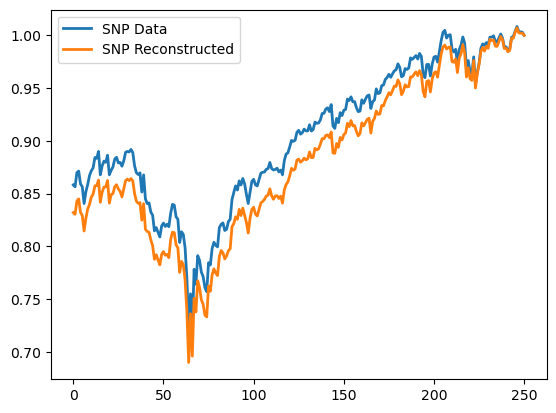

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(SNPData, label='SNP Data', linewidth=2)
ax.plot(pd.DataFrame(SNPReconstructed), label='SNP Reconstructed', linewidth=2)

leg = plt.legend()

plt.savefig('leg_example')
plt.show()

The key thing to note from the graph above is that the short-term fluctuations tend to mirror eachother, suggesting our estimates produce something in line with our desired result.

We can see that by extending weights backwards in time we get an under-estimate for the SNP 500 in previous periods. This is intuitive, as we are over-weighting stocks that are currently high in value but were much lower previously (causing their weights in the index to change). By over-weighting less valuable stocks in the past, we produce an underestimate. 

# ETF Weight Comparison

In [13]:
SPYurl = "https://www.ssga.com/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx"
SPYdf = pd.read_excel(SPYurl, skiprows=4)

SPYweights = dict(zip(SPYdf["Ticker"], SPYdf["Weight"]))
print("ETF Weights:")
for ticker, weight in SPYweights.items():
    print(ticker, weight)

ETF Weights:
NVDA 7.754701
AAPL 6.873724
MSFT 6.150519
AMZN 3.842213
GOOGL 3.116262
AVGO 2.796673
GOOG 2.496824
META 2.45991
TSLA 2.162313
BRK.B 1.577191
JPM 1.500936
LLY 1.460299
V 1.012759
XOM 0.868382
JNJ 0.852894
WMT 0.835949
MA 0.80096
PLTR 0.694782
ABBV 0.69069
NFLX 0.679813
COST 0.653962
BAC 0.632268
AMD 0.596605
HD 0.585794
PG 0.573013
ORCL 0.560957
GE 0.555961
MU 0.548184
CSCO 0.516652
UNH 0.511535
WFC 0.500608
CVX 0.493602
IBM 0.473766
KO 0.463117
CAT 0.458735
GS 0.451115
MRK 0.447044
CRM 0.431529
PM 0.42724
RTX 0.42041
ABT 0.372787
TMO 0.372511
MCD 0.372426
LRCX 0.367906
MS 0.366926
C 0.357271
AMAT 0.35032
DIS 0.347545
ISRG 0.343553
LIN 0.340677
AXP 0.339366
PEP 0.335794
INTU 0.316033
QCOM 0.31347
APP 0.312363
GEV 0.303416
AMGN 0.301713
T 0.301331
BKNG 0.29544
VZ 0.294077
TJX 0.292528
BA 0.290921
UBER 0.290512
NEE 0.286086
SCHW 0.285552
ACN 0.284704
INTC 0.283108
APH 0.283051
SPGI 0.277211
KLAC 0.273208
NOW 0.271931
- 0.269954
TXN 0.269736
BLK 0.263937
COF 0.263646
GILD 0.26

In [14]:
print("Difference between estimate and ETF:")
for ticker, weight in SPYweights.items():
    try:
        print(ticker, Weights[ticker] - weight)
    except:
        try:
            tickernormalised = ticker.replace(".", "-")
            print(ticker, Weights[tickernormalised] - weight)
        except:
            continue

Difference between estimate and ETF:
NVDA -0.3002362823246525
AAPL -0.13347731844883892
MSFT -0.22066001682937397
AMZN -0.14173147169842437
GOOGL 2.576026464503963
AVGO -2.556264705355169
GOOG 3.201123528784625
META -0.09230589912291398
TSLA -0.37881674490657447
BRK.B -1.5761451220430438
JPM -0.01757078991865435
LLY 0.1569236986369853
V 0.014366326364586346
XOM -0.003967202492869526
JNJ -0.010853200629937998
WMT -0.009986714223761406
MA 0.04701807935117075
PLTR -0.05832276933567271
ABBV -0.0037650960249179244
NFLX -0.031090103112458634
COST -0.011433034136267062
BAC 0.051238409172351784
AMD 0.008758720146144428
HD -0.0027697422931419746
PG -0.01299267712613894
ORCL 0.003505204758954661
GE 0.004050946017970181
MU 0.033543989801936513
CSCO -0.00847890856317568
UNH 0.0025977728822031976
WFC -0.0036716844040044494
CVX -0.0029400809438560604
IBM -0.013037319816411819
KO -0.009416263815361592
CAT 0.00963418355608714
GS 0.021761231998072617
MRK -0.0021993393500997493
CRM -0.037746117434647786

In [15]:
print("Significant Differences:")
for ticker, weight in SPYweights.items():
    try:
        if abs(Weights[ticker] - weight) < 0.1:
            continue
        print(ticker, Weights[ticker] - weight)
    except:
        try:
            tickernormalised = ticker.replace(".", "-")
            if abs(Weights[tickernormalised] - weight) < 0.1:
                continue
            print(ticker, Weights[tickernormalised] - weight)
        except:
            continue

Significant Differences:
NVDA -0.3002362823246525
AAPL -0.13347731844883892
MSFT -0.22066001682937397
AMZN -0.14173147169842437
GOOGL 2.576026464503963
AVGO -2.556264705355169
GOOG 3.201123528784625
TSLA -0.37881674490657447
BRK.B -1.5761451220430438
LLY 0.1569236986369853


We can see that most of the difference between our estimates and the weights that the SPY ETF uses are smaller than 0.1%, but we significantly over-allocate weights to GOOGL and GOOG, and under-allocate weight to AVGO and BRK.B. Less significantly we also over-allocate to LLY and under-allocate NVDA and TSLA. 

In [ ]:
BRK = yf.Ticker("BRK-B")
print(BRK.info["floatShares"])
print(BRK.info["sharesOutstanding"])
print(BRK.info["currentPrice"])
print(BRK.info["floatShares"]*BRK.info["currentPrice"])

We can see that for whatever reason yfinance significantly understates the float shares for BRK-B, at only 1M outstanding shares (less than 1% of shares outstanding) which is obviously not the true number of float shares. A quick check online reveals this number should indeed be much higher. This raises the concern that yfinance ticker info, while it provides meaningful and accuracte data most of the time, is not a reliable source of float share data. In the case of BRK.B, this mistake causes our code to estimate a weight of <0.1%, as opposed to the desired ~1.5%. The size of this discrepancy highlights the need for a more reliable source of FMC data. 

Given the drawbacks of the data explored here, it seems wise to use ETF holdings as a proxy for SNP constituent weights for all practical purposes, unless better FMC data is found. Below we can see that the SPY ETF tracks the SNP 500 perfectly, and the closeness of their weights to our FMC estimates (even with limited data) makes it reasonable to assume their holdings are reflective of the index.

In [ ]:
SPYData = NormaliseData(yf.download("SPY", period = Period, interval = Interval), "Open", True)

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(SNPData, label='SNP 500', linewidth=2)
ax.plot(SPYData, label='SPY', linewidth=2)

leg = plt.legend()

plt.savefig('leg_example')
plt.show()